In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests

from bs4 import BeautifulSoup
import QuantLib as ql

In [2]:
def get_date():
    headers = {'User-Agent': 'Mozilla/5.0'}
    req = requests.get('https://www.wsj.com/market-data/bonds', headers=headers)
    html = req.text
    soup = BeautifulSoup(html, 'html.parser')
    data = soup.find("span", class_ = "WSJBase--card__timestamp--3F2HxyAE")
    
    # JS path
    # document.querySelector("#root > div > div > div > div:nth-child(2) > div.style--grid--SxS2So51 > div > div:nth-child(2) > h3 > span.WSJBase--card__timestamp--3F2HxyAE > span")

    date = data.text
    date = datetime.datetime.strptime(date, "%m/%d/%y").date()
    return date


In [34]:
def get_quote(reference_date):
    tenors = ['01M', '03M', '06M', '01Y', '02Y', '03Y','05Y','07Y','10Y','30Y']

    # create empty lists
    maturities = []
    days = []
    prices = []
    coupons = []
    headers = {'User-Agent': 'Mozilla/5.0'}

    # get market informations
    for i, tenor in enumerate(tenors):
        url = "https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD"+tenor+"?mod=md_bond_overview_quote"
        req = requests.get(url, headers=headers)
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')

        # Price 
        data_src = soup.find("span", id="quote_val") 
        price = data_src.text
        price = float(price[:-1])
    
        data_src2 = soup.find_all("span", class_="data_data")

        # Coupon
        coupon = data_src2[2].text
        if coupon != '':
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
        
        # Maturity Date
        maturity = data_src2[3].text
        maturity = datetime.datetime.strptime(maturity, '%m/%d/%y').date()

        # Send to lists
        days.append((maturity - reference_date).days)
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
    
    # create dataframe
    df = pd.DataFrame([maturities, days, prices, coupons]).transpose()
    headers = ['maturity', 'days', 'price', 'coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)

    return df


In [120]:
def treasury_curve(date, quote):
    
    # Divide Quotes
    tbill = quote[0:4]
    tbond = quote[4:]
    
    # Set Evaluation Date
    eval_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = eval_date
    
    # Set Market Conventions
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    day_counter = ql.ActualActual()
    end_of_month = False
    fixing_days = 1
    face_amount = 100
    coupon_frequency = ql.Period(ql.Semiannual)
    
    # Construct Treasury Bill Helpers
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                         ql.Period(m, ql.Days),
                                         fixing_days,
                                         calendar,
                                         convention,
                                         end_of_month,
                                         day_counter)
                    for r, m in zip(tbill['price'], tbill['days'])]
    
    # Construct Treasury Bond Helpers
    bond_helpers = []
    for p, c, m in zip(tbond['price'], tbond['coupon'], tbond['days']):
        termination_date = eval_date + ql.Period(m, ql.Days)
        schedule = ql.Schedule(eval_date,
                               termination_date,
                               coupon_frequency,
                               calendar,
                               convention,
                               convention,
                               ql.DateGeneration.Backward,
                               end_of_month)
        bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(100)),
                                             fixing_days,
                                             face_amount,
                                             schedule,
                                             [c/100.0],
                                             day_counter,
                                             convention)
        bond_helpers.append(bond_helper)
    
    # Bind Helpers
    rate_helper = bill_helpers + bond_helpers
    
    # Build Curve
    yc_linearzero = ql.PiecewiseLinearZero(eval_date, rate_helper, day_counter)
    
    return yc_linearzero

In [121]:
def discount_factor(date, curve):
    # returns discount factors of each day
    # use quantlib date type
    print(date)
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

In [122]:
def zero_rate(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.ActualActual()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(date, day_counter, compounding, freq).rate()
    return zero_rate

In [123]:
ref_date = get_date()
quote = get_quote(ref_date)
print(quote)

             days  price coupon
maturity                       
2022-07-26     26  1.025    0.0
2022-09-29     91   1.71    0.0
2022-12-29    182  2.445    0.0
2023-06-15    350  2.841    0.0
2024-06-30    731  3.057    3.0
2025-06-15   1081  3.126  2.875
2027-06-30   1826  3.158   3.25
2029-06-30   2557   3.18   3.25
2032-05-15   3607  3.105  2.875
2052-05-15  10912  3.225  2.875


In [124]:
curve = treasury_curve(ref_date, quote)

In [126]:
discount_factor(quote.index[3], curve)

2023-06-15


0.9735481648804584

In [127]:
quote['discount factor'] = np.nan
quote['zero rate'] = np.nan

for date in quote.index:
    quote.loc[date, 'discount factor'] = discount_factor(date, curve)
    quote.loc[date, 'zero rate'] = zero_rate(date, curve)

print(quote[['discount factor', 'zero rate']])

2022-07-26
2022-09-29
2022-12-29
2023-06-15
2024-06-30
2025-06-15
2027-06-30
2029-06-30
2032-05-15
2052-05-15
            discount factor  zero rate
maturity                              
2022-07-26         0.999271   0.010271
2022-09-29         0.995805   0.016931
2022-12-29         0.988032   0.024292
2023-06-15         0.973548   0.028153
2024-06-30         0.942128   0.030009
2025-06-15         0.919057   0.028731
2027-06-30         0.850354   0.032685
2029-06-30         0.797277   0.032628
2032-05-15         0.756733   0.028425
2052-05-15         0.427408   0.028655


Text(0, 0.5, 'discount factor')

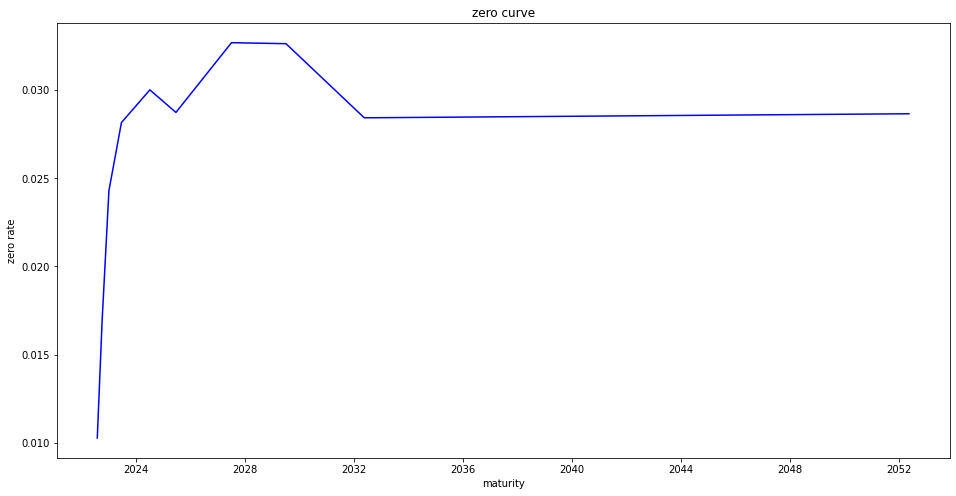

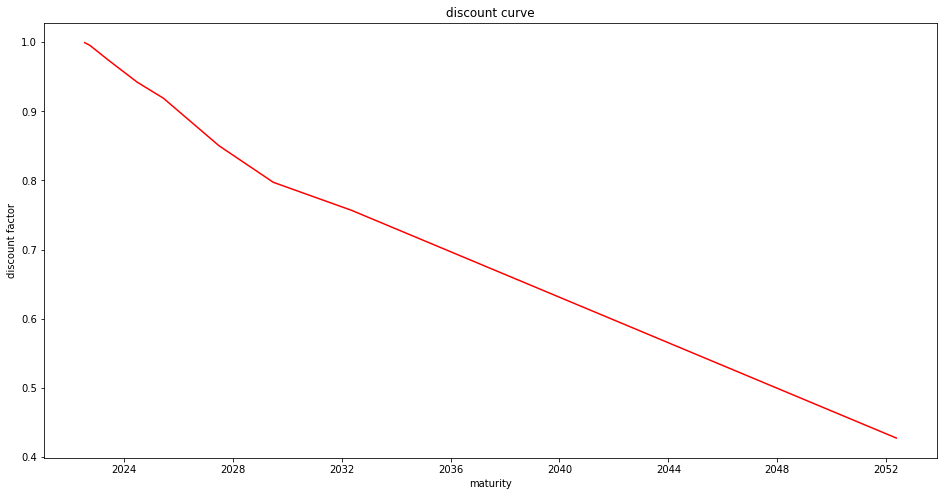

In [131]:
plt.figure(figsize=(16,8))
plt.plot(quote['zero rate'], 'b-')
plt.title('zero curve', loc='center')
plt.xlabel('maturity')
plt.ylabel('zero rate')

plt.figure(figsize=(16,8))
plt.plot(quote['discount factor'], 'r-')
plt.title('discount curve', loc='center')
plt.xlabel('maturity')
plt.ylabel('discount factor')